In [1]:
import requests
import gensim.downloader as api
import numpy as np

import re

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPooling1D, Conv1D, Embedding, Input, Add, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, auc, precision_recall_curve

In [2]:
data_train = requests.get('https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-train.conllu')
data_test = requests.get('https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-test.conllu')
data_dev = requests.get('https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-dev.conllu')

START = '__start__'
END = '__end__'
UNK = '__unk__'

In [3]:
def tokenizer(data):

  raw_text = data.text.strip()
  raw_docs = re.split(r'\n\t?\n', raw_text)
  token_docs = []
  tag_docs = []
  sentences = []

  for doc in raw_docs:
    tokens = [START] + [START]
    tags = []
    for line in doc.split('\n'):
      if (len(line.split('\t')) != 1):
        tokens.append(line.split('\t')[1].lower())
        tags.append(line.split('\t')[3])

    tokens.append(END)
    tokens.append(END)
    token_docs.append(tokens)
    tag_docs.append(tags)

  return  token_docs, tag_docs

#### Validity for pos tagging and tokens. Should have the same size (with substract 2 cause of the pseudotoken start & end

In [4]:
token_docs_train, tag_docs_train = tokenizer(data_train)
token_docs_test, tag_docs_test = tokenizer(data_test)
token_docs_dev, tag_docs_dev = tokenizer(data_dev)

#validity for pos tagging and tokens.
for i in range(len(token_docs_train)):
  if len(token_docs_train[i]) - len(tag_docs_train[i]) != 4:
    print(i)

#### Size of training, development and test datasets

In [5]:
print('Training sentences :', len(token_docs_train))
print('Test sentences :', len(token_docs_test))
print('Development sentences :', len(token_docs_dev))

Training sentences : 8548
Test sentences : 1096
Development sentences : 1117


### Get Number of labels and check support for each label

##### '_' ---> word contains apostrophe while 'X' ---> not english

In [6]:
flatten_tags_dev = [t for tag in tag_docs_dev for t in tag]
flatten_tags_test = [t for tag in tag_docs_test for t in tag]
flatten_tags_train = [t for tag in tag_docs_train for t in tag]

print('Training set labels :', sorted(set(flatten_tags_train)))
print('Test set labels :', sorted(set(flatten_tags_test)))
print('Development set labels :', sorted(set(flatten_tags_dev)))

N_CLASSES = len(set(flatten_tags_train))
print('\nNumber of labels :', N_CLASSES)
print('Vocabulary size :', len(set(t for token in token_docs_train for t in token)) - 2)


def average_sentence_length(sentences):
  sent_sizes = []

  for sent in sentences:
    sent_sizes.append(len(sent) - 2)

  return int(np.mean(np.array(sent_sizes)))

print('\nAverage sentence length of training set :', average_sentence_length(token_docs_train))
print('Average sentence length of development set :', average_sentence_length(token_docs_dev))
print('Average sentence length of test set :', average_sentence_length(token_docs_test))

Training set labels : ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', '_']
Test set labels : ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', '_']
Development set labels : ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', '_']

Number of labels : 18
Vocabulary size : 14826

Average sentence length of training set : 19
Average sentence length of development set : 19
Average sentence length of test set : 20


### Create d-Window mini-sentences

In [7]:
def window_tokenized(WINDOW_NUMBER, token_docs):
  windowed_token_docs = []
  for sent in token_docs:
    temp = [[sent[idx + i] for i in range(WINDOW_NUMBER)] for idx in range(len(sent) - WINDOW_NUMBER + 1)]
    windowed_token_docs.append(temp)

  return [window for m_sentence in windowed_token_docs for window in m_sentence]

In [8]:
WINDOW = 5

windowed_token_docs_train = window_tokenized(WINDOW, token_docs_train)
windowed_token_docs_test = window_tokenized(WINDOW, token_docs_test)
windowed_token_docs_dev = window_tokenized(WINDOW, token_docs_dev)


print('Training mini-sentences :', len(windowed_token_docs_train), 'and Training y_true :', len(flatten_tags_train))
print('Test mini-sentences :', len(windowed_token_docs_test), 'and Test y_true :', len(flatten_tags_test))
print('Development mini-sentences :', len(windowed_token_docs_dev), 'and Development y_true :', len(flatten_tags_dev))

Training mini-sentences : 150374 and Training y_true : 150374
Test mini-sentences : 20195 and Test y_true : 20195
Development mini-sentences : 19997 and Development y_true : 19997


### Create 1-hot vectors for y_true label

In [9]:
mlb = MultiLabelBinarizer()

y_train_1_hot  = mlb.fit_transform([[tag] for tag in flatten_tags_train])
y_test_1_hot  = mlb.transform([[tag] for tag in flatten_tags_test])
y_dev_1_hot  = mlb.transform([[tag] for tag in flatten_tags_dev])

# Indexing and embedding

In [10]:
embeddings = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [11]:
vocab = set(t for token in token_docs_train for t in token)
VOCAB_SIZE = len(vocab)

word_index = dict()

for i, word in enumerate(vocab):
  word_index[word] = i

word_index[UNK] = VOCAB_SIZE


def replace_with_index(windowed_token_docs, word_idx):

    doc_tokenized = []

    for mini_sent in windowed_token_docs:
      doc_tokenized.append([word_idx[UNK] if word not in word_idx.keys() else word_idx[word] for word in mini_sent])

    return np.array(doc_tokenized)


train_data = replace_with_index(windowed_token_docs_train, word_index)
dev_data = replace_with_index(windowed_token_docs_dev, word_index)
test_data = replace_with_index(windowed_token_docs_test, word_index)

print(train_data[0])
print(train_data[1])
print(word_index[START])

[2857 2857 8313 1000 4170]
[ 2857  8313  1000  4170 14030]
2857


In [12]:
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

count = 0
for i, word in enumerate(vocab):

    try:
        embedding_matrix[i] = embeddings[word]
        count += 1
    except:
        pass


print(len(np.unique(np.nonzero(embedding_matrix)[0])))
print(count)

del embeddings

13709
13709


# Model creation and hyper-parameter tuning

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
BATCH_SIZE = 256
EPOCHS = 15
FILTERS = EMBEDDING_DIM
KERNEL = 3

import keras_tuner as kt


def model_builder(hp):

  # Hyperparameters to tune
  hp_stack = hp.Int('stacks', min_value=1, max_value=3, step=1)
  hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
  hp_dropout = hp.Float('rate', min_value=0.1, max_value=0.5, step=0.2)
  hp_learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, step=10, sampling='log')


  inputs = Input((WINDOW,))

  # Embedding layer
  embeddings = Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                          input_length=WINDOW, mask_zero=True, trainable=False)(inputs)

  x = Dropout(rate=hp_dropout)(embeddings)


  fx = Conv1D(filters=FILTERS, kernel_size=KERNEL, strides=1, activation='relu', padding='same', name='{}-gram_Convolutions{}'.format(KERNEL, 1))(x)

  # Stack CNNs
  for i in range(1, hp_stack):

    input = fx

    fx = Conv1D(filters=FILTERS, kernel_size=KERNEL, strides=1, activation='relu', padding='same', name='{}-gram_Convolutions{}'.format(KERNEL, i+1))(input)

    # Residual Connection
    fx = Add()([input,fx])
    fx = BatchNormalization()(fx)
    # fx = ReLU()(fx)

  pooled_x = GlobalMaxPooling1D()(fx)

  drop_x = Dropout(rate=hp_dropout)(pooled_x)


  # Αdd the output MLP layer
  x = Dense(units=hp_units, activation="relu")(drop_x)

  drop_out = Dropout(rate=hp_dropout)(x)

  out = Dense(units=N_CLASSES, activation="softmax")(drop_out)


  model = Model(inputs=inputs, outputs=out)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(
                from_logits=False),
                optimizer=Adam(learning_rate=hp_learning_rate),
                metrics=["accuracy"])

  return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=EPOCHS,
                     factor=3,
                     directory='my_dir4',
                     project_name='intro_to_kt')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


tuner.search(train_data, y_train_1_hot, epochs=10, validation_data=(dev_data, y_dev_1_hot), callbacks=[stop_early], batch_size=BATCH_SIZE)


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. We stacked {best_hps.get('stacks')} CNNs. The optimal number of units in the densely-connected
layer is {best_hps.get('units')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and the dropout probability is: {best_hps.get('rate')}.
""")

Trial 30 Complete [00h 12m 33s]
val_accuracy: 0.9181877374649048

Best val_accuracy So Far: 0.9282892346382141
Total elapsed time: 03h 55m 58s

The hyperparameter search is complete. We stacked 3 CNNs. The optimal number of units in the densely-connected
layer is 32, the optimal learning rate for the optimizer
is 0.01 and the dropout probability is: 0.30000000000000004.



In [ ]:
model = tuner.hypermodel.build(best_hps)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 5, 300)               4448700   ['input_2[0][0]']             
                                                                                                  
 dropout_3 (Dropout)         (None, 5, 300)               0         ['embedding_1[0][0]']         
                                                                                                  
 3-gram_Convolutions1 (Conv  (None, 5, 300)               270300    ['dropout_3[0][0]']           
 1D)                                                                                        

Epoch 1/15
588/588 [==============================] - 172s 288ms/step - loss: 1.3031 - accuracy: 0.5715 - val_loss: 0.5865 - val_accuracy: 0.8038
Epoch 2/15
588/588 [==============================] - 154s 262ms/step - loss: 0.6181 - accuracy: 0.8071 - val_loss: 0.3720 - val_accuracy: 0.8785
Epoch 3/15
588/588 [==============================] - 149s 253ms/step - loss: 0.4112 - accuracy: 0.8725 - val_loss: 0.3045 - val_accuracy: 0.8991
Epoch 4/15
588/588 [==============================] - 150s 256ms/step - loss: 0.3383 - accuracy: 0.8968 - val_loss: 0.3103 - val_accuracy: 0.9031
Epoch 5/15
588/588 [==============================] - 155s 263ms/step - loss: 0.2921 - accuracy: 0.9108 - val_loss: 0.2760 - val_accuracy: 0.9126
Epoch 6/15
588/588 [==============================] - 150s 256ms/step - loss: 0.2637 - accuracy: 0.9192 - val_loss: 0.2712 - val_accuracy: 0.9163
Epoch 7/15
588/588 [==============================] - 149s 253ms/step - loss: 0.2427 - accuracy: 0.9260 - val_loss: 0.2635 -

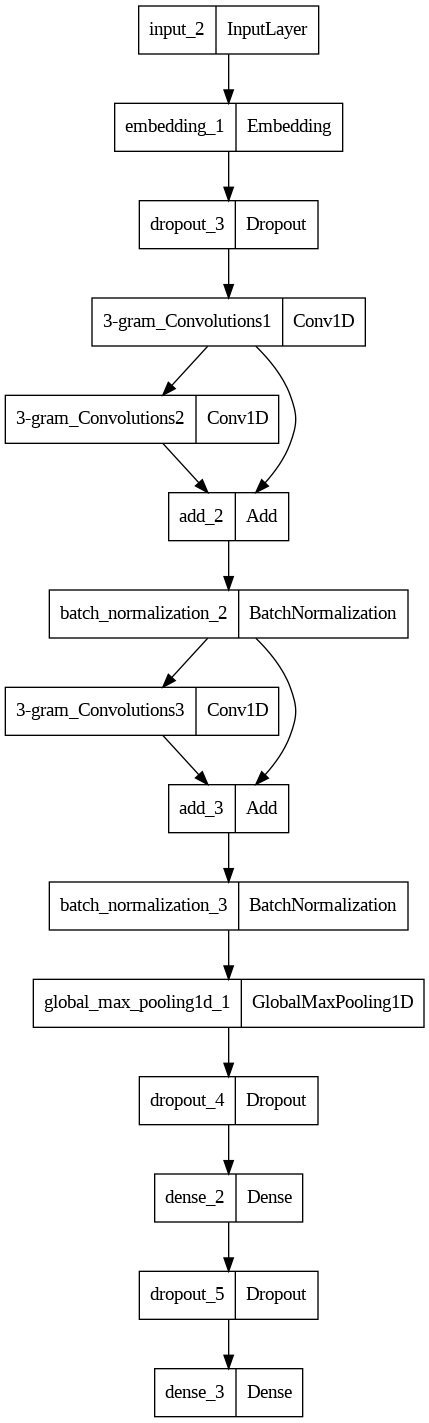

In [14]:
import time

with tf.device('/device:GPU:0'):

  start_training_time = time.time()

  history = model.fit(train_data,
                    y_train_1_hot,
                    validation_data=(dev_data, y_dev_1_hot),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True)

  end_training_time = time.time()

  print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

%matplotlib notebook

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import Image
Image('model.png')

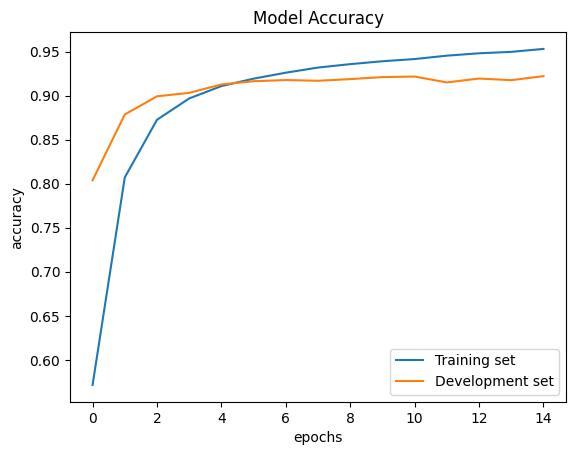

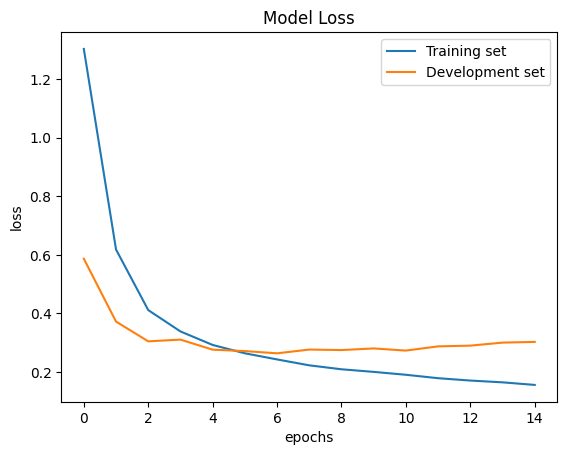

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Training set', 'Development set'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Training set', 'Development set'], loc='upper right')
plt.show()

# Metrics

Precision , Recall , F1 , AUC scores for CNN classifier

In [16]:
def prec_rec_auc(y_true, y_pred, N_CLASSES):
  precision = dict()
  recall = dict()
  auc_score = dict()

  for i in range(N_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    auc_score[mlb.classes_[i]] = auc(recall[i], precision[i])

  return precision, recall, auc_score


def macro_auc(auc_scores):
  auc = []

  for key in auc_scores.keys():
    auc.append(auc_scores[key])

  return np.mean(np.array(auc))


model = tuner.hypermodel.build(best_hps)
model.fit(train_data, y_train_1_hot, validation_data=(dev_data, y_dev_1_hot), batch_size=BATCH_SIZE, epochs=best_epoch, shuffle=True)


cnn_predictions_train = model.predict(train_data)
_, _, cnn_auc_train = prec_rec_auc(y_train_1_hot, cnn_predictions_train, N_CLASSES)

cnn_predictions_dev = model.predict(dev_data)
_, _, cnn_auc_dev = prec_rec_auc(y_dev_1_hot, cnn_predictions_dev, N_CLASSES)

cnn_predictions_test = model.predict(test_data)
_, _, cnn_auc_test = prec_rec_auc(y_test_1_hot, cnn_predictions_test, N_CLASSES)



print('\n--------- Custom stacked CNN ---------\n')
print('Training set\n')
print(classification_report(y_train_1_hot, np.round(cnn_predictions_train), target_names = mlb.classes_, zero_division=0.0))
print('AUC training :', cnn_auc_train, '\n')
print('Macro AUC :', macro_auc(cnn_auc_train), '\n')
print('\nDevelopment set\n')
print(classification_report(y_dev_1_hot, np.round(cnn_predictions_dev), target_names = mlb.classes_, zero_division=0.0))
print('AUC development :', cnn_auc_dev, '\n')
print('Macro AUC :', macro_auc(cnn_auc_dev), '\n')
print('\nTest set\n')
print(classification_report(y_test_1_hot, np.round(cnn_predictions_test), target_names = mlb.classes_, zero_division=0.0))
print('AUC test :', cnn_auc_test, '\n')
print('Macro AUC :', macro_auc(cnn_auc_test), '\n')

Epoch 1/10
588/588 [==============================] - 157s 263ms/step - loss: 1.1677 - accuracy: 0.6196 - val_loss: 0.5368 - val_accuracy: 0.8248
Epoch 2/10
588/588 [==============================] - 151s 256ms/step - loss: 0.5817 - accuracy: 0.8222 - val_loss: 0.3692 - val_accuracy: 0.8818
Epoch 3/10
588/588 [==============================] - 150s 255ms/step - loss: 0.4038 - accuracy: 0.8766 - val_loss: 0.3041 - val_accuracy: 0.9046
Epoch 4/10
588/588 [==============================] - 150s 256ms/step - loss: 0.3289 - accuracy: 0.8999 - val_loss: 0.2984 - val_accuracy: 0.9086
Epoch 5/10
588/588 [==============================] - 152s 259ms/step - loss: 0.2903 - accuracy: 0.9115 - val_loss: 0.2754 - val_accuracy: 0.9115
Epoch 6/10
588/588 [==============================] - 150s 255ms/step - loss: 0.2595 - accuracy: 0.9201 - val_loss: 0.2669 - val_accuracy: 0.9174
Epoch 7/10
588/588 [==============================] - 148s 252ms/step - loss: 0.2408 - accuracy: 0.9260 - val_loss: 0.3035 -